cell 1 buat import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import joblib
import glob
import seaborn as sns

cell 2, disini buat nge apply greyscale ama segmentasiin pake ostu

In [2]:
def preprocess(img, use_blur=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    if use_blur:
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
    return gray

def segment(img_gray, invert_mask=True):
    thresh1 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, thresh2 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    combined = cv2.bitwise_and(thresh1, thresh2)

    kernel = np.ones((7, 7), np.uint8)
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    if invert_mask:
        opened = cv2.bitwise_not(opened)

    return combined, closed, opened

def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

cell 3 baut extract bentuk dari hasil segmentasi sebelumnyha pake hu_momoents, warna pake hsv, ama texture pake glcm, berdasarkan yang udah kita buat di paper

In [3]:
def plot_hsv_histogram(hsv_masked):
    h, s, v = cv2.split(hsv_masked)
    h = h[h > 0]
    s = s[s > 0]
    v = v[v > 0]

    plt.subplot(3, 1, 1)
    plt.hist(h.ravel(), bins=180, color='r')
    plt.title("Hue Distribution")

    plt.subplot(3, 1, 2)
    plt.hist(s.ravel(), bins=256, color='g')
    plt.title("Saturation Distribution")

    plt.subplot(3, 1, 3)
    plt.hist(v.ravel(), bins=256, color='b')
    plt.title("Value Distribution")

def prepare_texture_image(gray, mask):
    texture_masked = apply_mask(gray, mask)
    return texture_masked

cell 3.1 buat definisiin hasil segmentasi, extract warna, dan texture

In [4]:
image_paths = glob.glob("coba*.jpg")
if not image_paths:
    print("Tidak ditemukan file yang diawali dengan nama 'coba'.")
else:
    image_path = image_paths[0]
    img = cv2.imread(image_path)
    resized = cv2.resize(img, (200, 200))

    gray_blur = preprocess(resized, use_blur=True)
    gray_no_blur = preprocess(resized, use_blur=False)

    otsu1, closed_blur, opened_blur = segment(gray_blur)
    otsu2, closed_noblur, opened_noblur = segment(gray_no_blur)

    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    hsv_masked = apply_mask(hsv, opened_noblur)

    texture_img = prepare_texture_image(gray_no_blur, opened_noblur)
    glcm = graycomatrix(texture_img, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    glcm_vis = glcm[:, :, 0, 0]
    glcm_vis_norm = cv2.normalize(glcm_vis, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")


cell 3.2 buat plotting segmentasi

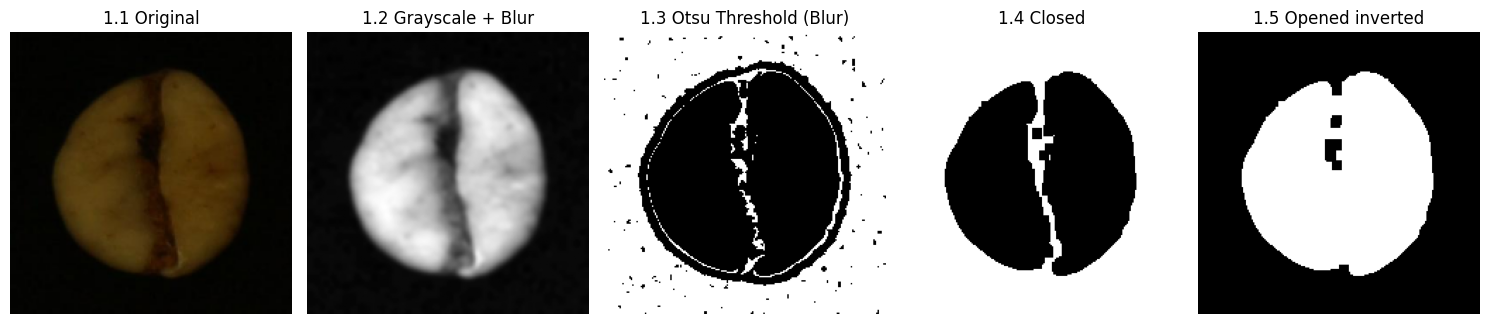

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("1.1 Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(gray_blur, cmap='gray')
plt.title("1.2 Grayscale + Blur")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(otsu1, cmap='gray')
plt.title("1.3 Otsu Threshold (Blur)")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(closed_blur, cmap='gray')
plt.title("1.4 Closed")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(opened_blur, cmap='gray')
plt.title("1.5 Opened inverted")
plt.axis("off")

plt.tight_layout()
plt.show()

cell 3.3 buat plotting extraksi warna

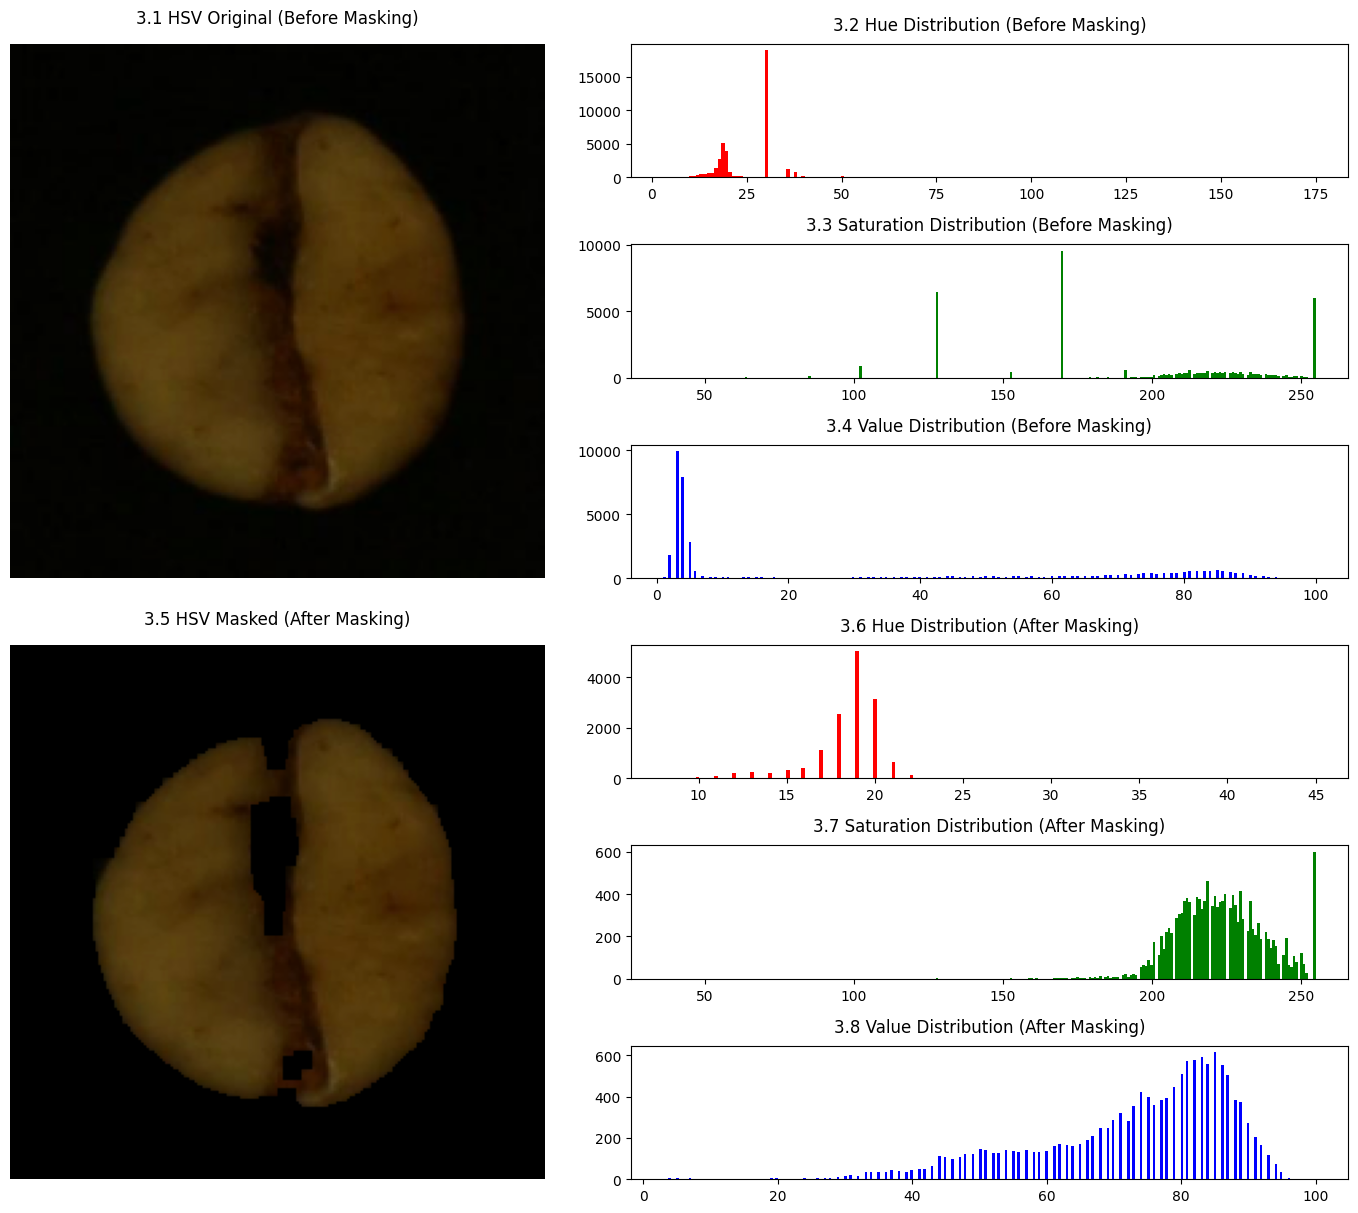

In [6]:
hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
hsv_masked = apply_mask(hsv, opened_noblur)

h1, s1, v1 = cv2.split(hsv)
h1 = h1[h1 > 0]
s1 = s1[s1 > 0]
v1 = v1[v1 > 0]

h2, s2, v2 = cv2.split(hsv_masked)
h2 = h2[h2 > 0]
s2 = s2[s2 > 0]
v2 = v2[v2 > 0]

fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.2], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
ax0.set_title("3.1 HSV Original (Before Masking)", pad=15)
ax0.axis("off")

gs_hist1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0, 1], hspace=0.5)
ax1 = fig.add_subplot(gs_hist1[0])
ax2 = fig.add_subplot(gs_hist1[1])
ax3 = fig.add_subplot(gs_hist1[2])

ax1.hist(h1.ravel(), bins=180, color='red')
ax1.set_title("3.2 Hue Distribution (Before Masking)", pad=10)

ax2.hist(s1.ravel(), bins=256, color='green')
ax2.set_title("3.3 Saturation Distribution (Before Masking)", pad=10)

ax3.hist(v1.ravel(), bins=256, color='blue')
ax3.set_title("3.4 Value Distribution (Before Masking)", pad=10)

ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB))
ax4.set_title("3.5 HSV Masked (After Masking)", pad=15)
ax4.axis("off")

gs_hist2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1, 1], hspace=0.5)
ax5 = fig.add_subplot(gs_hist2[0])
ax6 = fig.add_subplot(gs_hist2[1])
ax7 = fig.add_subplot(gs_hist2[2])

ax5.hist(h2.ravel(), bins=180, color='red')
ax5.set_title("3.6 Hue Distribution (After Masking)", pad=10)

ax6.hist(s2.ravel(), bins=256, color='green')
ax6.set_title("3.7 Saturation Distribution (After Masking)", pad=10)

ax7.hist(v2.ravel(), bins=256, color='blue')
ax7.set_title("3.8 Value Distribution (After Masking)", pad=10)

plt.tight_layout(rect=[0, 0, 1, 1.02])
plt.show()

cell 3.4 buat plotting extraksi texture

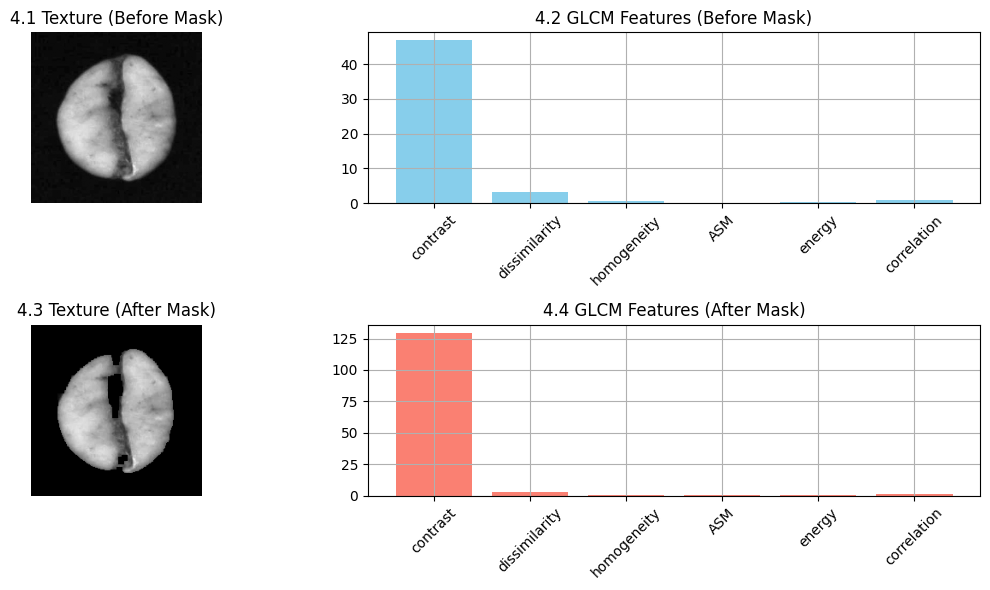

In [7]:
texture_before = prepare_texture_image(gray_no_blur, mask=None)
glcm_before = graycomatrix(texture_before, distances=[1], angles=[0],
                           levels=256, symmetric=True, normed=True)
glcm_before_vis = glcm_before[:, :, 0, 0]
glcm_before_norm = cv2.normalize(glcm_before_vis, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

texture_after = prepare_texture_image(gray_no_blur, opened_noblur)
glcm_after = graycomatrix(texture_after, distances=[1], angles=[0],
                          levels=256, symmetric=True, normed=True)
glcm_after_vis = glcm_after[:, :, 0, 0]
glcm_after_norm = cv2.normalize(glcm_after_vis, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
glcm_features_before = [graycoprops(glcm_before, prop)[0, 0] for prop in props]
glcm_features_after = [graycoprops(glcm_after, prop)[0, 0] for prop in props]

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(texture_before, cmap='gray')
plt.title("4.1 Texture (Before Mask)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.bar(props, glcm_features_before, color='skyblue')
plt.title("4.2 GLCM Features (Before Mask)")
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.imshow(texture_after, cmap='gray')
plt.title("4.3 Texture (After Mask)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.bar(props, glcm_features_after, color='salmon')
plt.title("4.4 GLCM Features (After Mask)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


cell 3.9 pendefinisian hasil dari extract features hsv warna dan glcm texture

In [8]:
def extract_features(segmented_mask, original_image):
    segmented_mask = cv2.resize(segmented_mask, (original_image.shape[1], original_image.shape[0]))
    
    masked_image = cv2.bitwise_and(original_image, original_image, mask=segmented_mask)

    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    mean_h = np.mean(h[segmented_mask > 0])
    mean_s = np.mean(s[segmented_mask > 0])
    mean_v = np.mean(v[segmented_mask > 0])
    hsv_features = [mean_h, mean_s, mean_v]

    gray_masked = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    gray_masked[segmented_mask == 0] = 0
    glcm = graycomatrix(gray_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]
    texture_features = [contrast, homogeneity, energy, correlation]

    features = hsv_features + texture_features
    return features

cell 4 buat training, dataset di seimbangkan dengan emnyamakan semua jumlah image setiap kelas yang ada dengan kelas yg paling dikit

In [9]:
def load_dataset(folder):
    df = pd.read_csv(os.path.join(folder, '_classes.csv'))
    data_per_class = defaultdict(list)

    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping {row['filename']} karena tidak bisa dibaca.")
            continue

        gray = preprocess(img)
        _, _, final_mask = segment(gray)
        
        feats = extract_features(final_mask, img)

        if feats is not None:
            label_col = row.index[1:]
            label_val = row.iloc[1:]
            label = label_col[label_val == 1].values[0]
            data_per_class[label].append((feats, label))

    min_samples = min(len(v) for v in data_per_class.values())

    X, y = [], []
    for samples in data_per_class.values():
        selected = samples[:min_samples]
        for feat, label in selected:
            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)

X_train, y_train = load_dataset("train")
X_valid, y_valid = load_dataset("valid")
X_test, y_test = load_dataset("test")

import collections
print(collections.Counter(y_train))

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Counter({'Robusta': 402, 'Arabika': 402, 'Liberika': 402})
Train: (1206, 7) Valid: (153, 7) Test: (153, 7)


cell 5

In [10]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01],
    'svc__kernel': ['rbf', 'poly']
}

clf = make_pipeline(
    StandardScaler(),
    SVC(probability=True, class_weight='balanced')
)

print("Training model with GridSearchCV...")
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train_enc)

best_clf = grid_search.best_estimator_

print("\nBest parameters found:")
print(grid_search.best_params_)

Training model with GridSearchCV...

Best parameters found:
{'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


cell 6 buat nampilin hasil training nya

In [11]:
y_test_enc = le.transform(y_test)
y_pred_enc = best_clf.predict(X_test)

print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))

              precision    recall  f1-score   support

     Arabika       0.76      0.73      0.74        51
    Liberika       0.85      0.80      0.83        51
     Robusta       0.66      0.73      0.69        51

    accuracy                           0.75       153
   macro avg       0.76      0.75      0.75       153
weighted avg       0.76      0.75      0.75       153



cell 7 save hasil model ama labelnya pake formatnya pkl biar gampang

In [12]:
joblib.dump(best_clf, "coffee_classifier.pkl")
joblib.dump(le, "label_encoder.pkl")
print("model n label selesai disave.")

model n label selesai disave.


cell 8 buat testing, testingnya udah di pisahin dan di taro di 3 folder "randomtest*", keluarkan salah satu gambar ke root untuk nge test gambar tersebut

klo mau langsung jalanin testing nya aja menggunakan model .pkl nya, pastiin udah run import libraries nya dulu di cel 1 (paling atas)

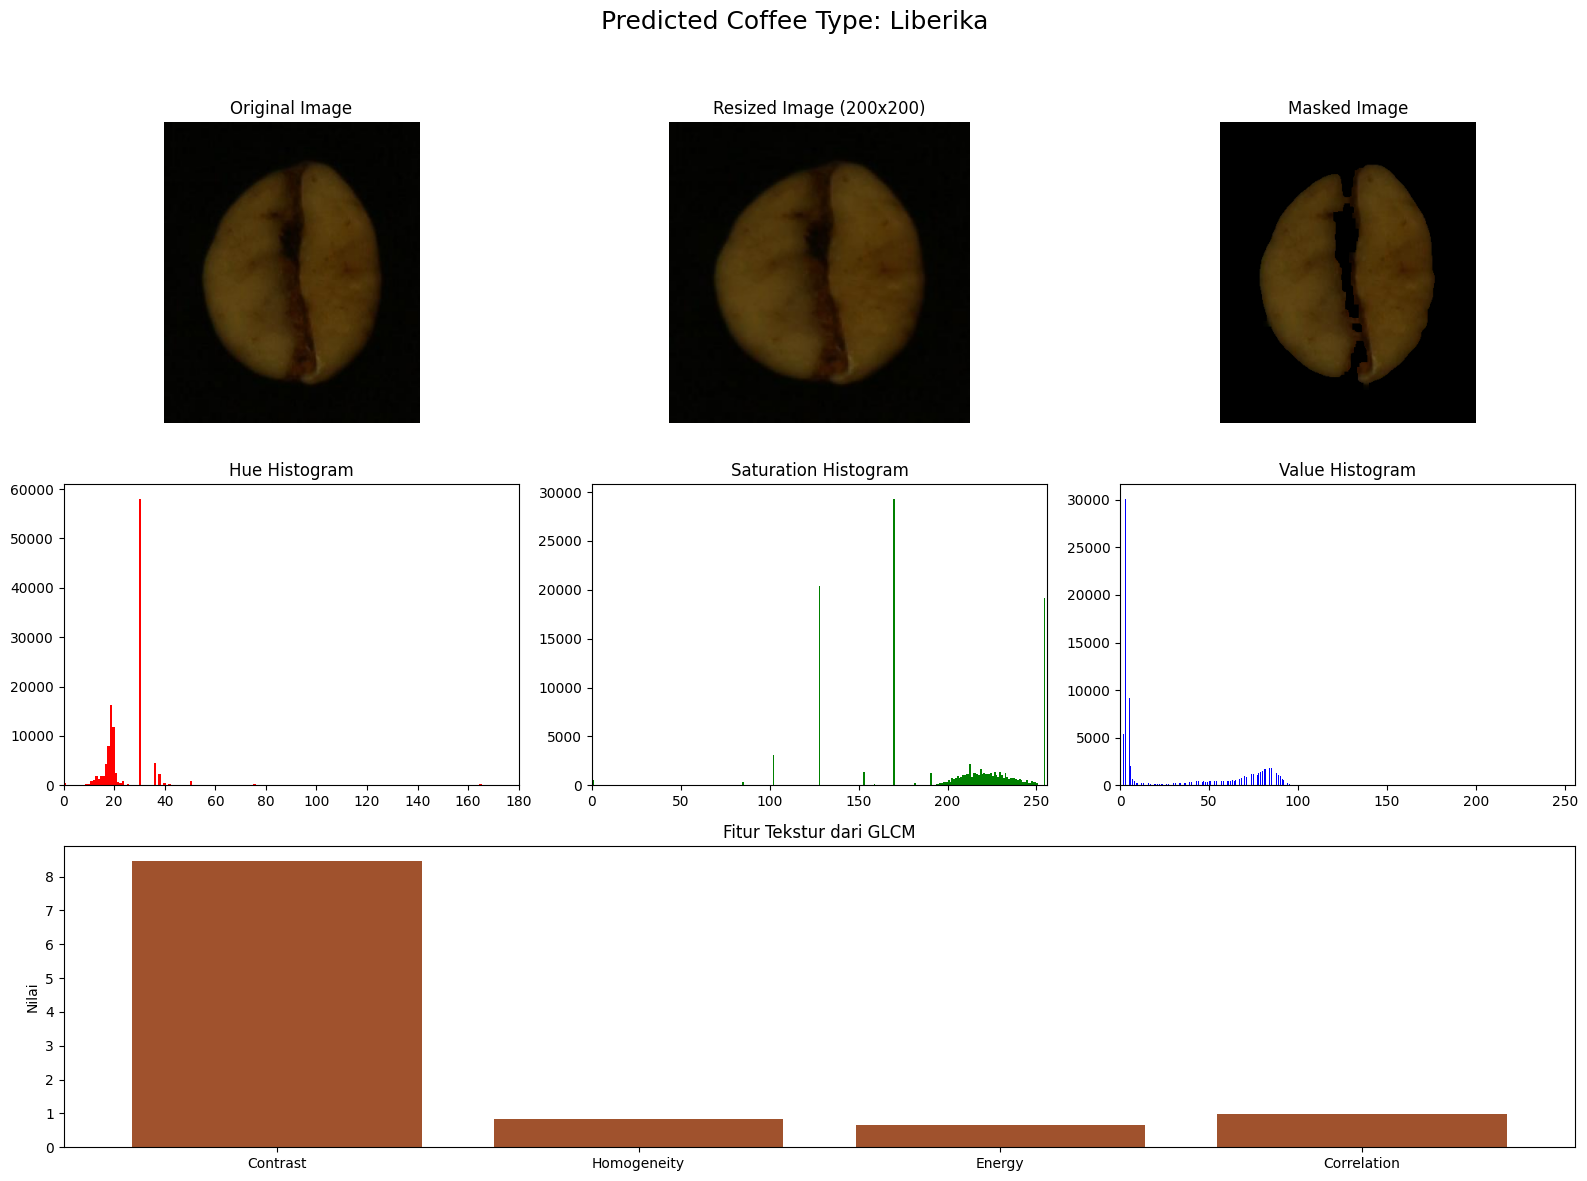

In [13]:
clf = joblib.load("coffee_classifier.pkl")
le = joblib.load("label_encoder.pkl")

def predict_single_image(image_path, clf, le):
    img = cv2.imread(image_path)
    if img is None:
        print("Gambar tidak bisa dibaca.")
        return

    gray = preprocess(img)
    _, _, mask = segment(gray)

    masked_image = apply_mask(img, mask)

    feats = extract_features(mask, img)
    if feats is None:
        print("Gagal ekstrak fitur, coba gambar lain.")
        return

    feats = np.array(feats).reshape(1, -1)
    pred_enc = clf.predict(feats)
    pred_label = le.inverse_transform(pred_enc)[0]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    fig = plt.figure(figsize=(16, 12))

    ax1 = fig.add_subplot(3, 3, 1)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Image")
    ax1.axis('off')

    ax2 = fig.add_subplot(3, 3, 2)
    resized = cv2.resize(img, (200, 200))
    ax2.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    ax2.set_title("Resized Image (200x200)")
    ax2.axis('off')

    ax3 = fig.add_subplot(3, 3, 3)
    ax3.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    ax3.set_title("Masked Image")
    ax3.axis('off')

    ax4 = fig.add_subplot(3, 3, 4)
    ax4.hist(h.ravel(), bins=180, color='r')
    ax4.set_title("Hue Histogram")
    ax4.set_xlim([0, 180])

    ax5 = fig.add_subplot(3, 3, 5)
    ax5.hist(s.ravel(), bins=256, color='g')
    ax5.set_title("Saturation Histogram")
    ax5.set_xlim([0, 256])

    ax6 = fig.add_subplot(3, 3, 6)
    ax6.hist(v.ravel(), bins=256, color='b')
    ax6.set_title("Value Histogram")
    ax6.set_xlim([0, 256])

    ax7 = fig.add_subplot(3, 1, 3)
    texture_names = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
    texture_values = feats.flatten()[-4:]
    ax7.bar(texture_names, texture_values, color='sienna')
    ax7.set_title("Fitur Tekstur dari GLCM")
    ax7.set_ylabel("Nilai")

    fig.suptitle(f"Predicted Coffee Type: {pred_label}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

image_paths = glob.glob("coba*.jpg")
if image_paths:
    predict_single_image(image_paths[0], clf, le)
else:
    print("Tidak ditemukan gambar yang cocok dengan pola 'coba*.jpg'")

cell 9 buat ngecheck tabel evaluasinya

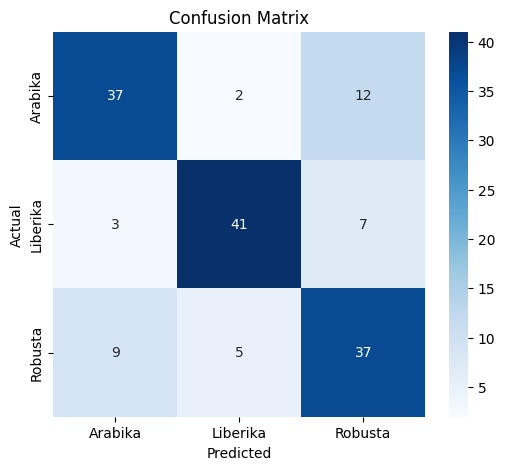

      Class  TP  FP  FN  TN
0   Arabika  37  12  14  90
1  Liberika  41   7  10  95
2   Robusta  37  19  14  83


In [14]:
clf = joblib.load("coffee_classifier.pkl")
le = joblib.load("label_encoder.pkl")

y_test_enc = le.transform(y_test)

y_pred_enc = clf.predict(X_test)

cm = confusion_matrix(y_test_enc, y_pred_enc)
labels = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

confusion_table = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    confusion_table.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

df_confusion = pd.DataFrame(confusion_table)
print(df_confusion)
